Join the data from Part 1 with the data from Part 2 to create a new dataframe.

In [9]:
import requests, pandas as pd, json
####get citybikes dataframe###########################################
response = requests.get('http://api.citybik.es/v2/networks')
data = response.json()
#nested dictionary structure, look for specific city in this case Paris because the documentation used it as an example
def get_citybikes_by_city(city):
    """
    this is my functiont that takes a string city name as a paremeter and returns a dataframe of the nearby citybikes
    """
    response = requests.get(f"http://api.citybik.es/v2/networks/velib")
    jsonobject = response.json()
    stations = jsonobject['network']['stations']
    df = pd.DataFrame(stations)
    return df

df = get_citybikes_by_city("Paris")

#normalize the object['extra'] column
df_extra = pd.json_normalize(df['extra'])
df = pd.concat([df, df_extra], axis=1)
df.drop('extra', axis=1, inplace=True)

print(df.head())
#################get foursquare dataframe#############################


#using paris as an example 
lattitude = 48.8588548
longitude = 2.347035

def get_json_by_ll(lattitude,longitude):
    """
    this function takes two integers as input, lattitude adn longitude.
    it returns a json object to convert to dataframe
    """
    #construct the url witht he requests library functions
    url = "https://api.foursquare.com/v3/places/search"
    params = {
        "ll": str(lattitude)+","+str(longitude),
        "radius": 1000,
        "fields": "categories,rating,geocodes,categories,location,name,fsq_id,stats,price",
        "limit": 50
    }
    headers = {
        "accept": "application/json",
        "Authorization": "fsq3aB5c7PNhhqT23DewFyJ7Easfex4oG/ymaLVxSui+7VE="
    }
    
    response = requests.get(url, params=params, headers=headers)
    data = response.json()
    ratings = [place.get('rating', 0) for place in data.get('results', [])]
    return data
response = get_json_by_ll(lattitude,longitude)

def get_fs_data(jsonresponse):
    """
    this is a function that takes the json response and uses getter functions on the data structure 
    to return required details, it returns a list of details to be used in a dataframe
    """
    poi_details = [] # POI - point of interest 
    for poi in response.get('results', []):
        idd = poi.get('fsq_id', 0)
        name = poi.get('name', 'no data')
        rating = poi.get('rating', 0)
        location = poi.get('location', {}).get('formatted_address', 'no data')
        categories = poi.get('categories','no data')
        poi_info = {
            "id": idd,
            "name": name,
            "rating": rating,
            "location": location,
        }


        poi_details.append(poi_info)
    return poi_details
list_of_stuff = get_fs_data(response)
# Create DataFrame
df1 = pd.DataFrame(list_of_stuff)

# Print the DataFrame
print(df1)
########get the yelp data##########################################################################
def yelp_json_by_name(name):
    API_KEY = "V6RfSQbnmYuJu5EBRgRikoCk-ScXUU38_M1rKj4CxeKGqmL0nGd1iLhkloqMVAsUK7uYrlpyE4OrIDRIrNO5lEPo60qcEEitGxX7tNBr8hRNu4RTHSKV_IztV2h7ZHYx"
    BASE_URL = "https://api.yelp.com/v3"
    term = "bike stations"
    location = name
    headers = {
        "Authorization": f"Bearer {API_KEY}"
    }
    params = {
        "term": term,
        "location": location,
        "radius": 1000
    }
    url = f"{BASE_URL}/businesses/search"
    response = requests.get(url, headers=headers, params=params)
    return response.json()
data = yelp_json_by_name("Paris")

def get_yelp_data(json):   
    names = []
    ratings = []
    addresses = []
    phones = []
    
    for business in json['businesses']:
        names.append(business['name'])
        ratings.append(business.get('rating', 0))
        addresses.append(', '.join(business['location']['display_address']))
        phones.append(business.get('phone', 'no data'))
        
    data_dict = {
        'names': names,
        'ratings': ratings,
        'addresses': addresses,
        'phones': phones
    }
    
    return data_dict

result = get_yelp_data(data)

dictionary_to_use = get_yelp_data(data)
df2 = pd.DataFrame({
    'name': names,
    'rating': ratings,
    'addresses': addresses,
    'phone': phones
})
print(df2)

##########Concatenate the dataframes####################################################################
combined_df = pd.concat([df1, df2], ignore_index=True)

# combine df with combined_df
final_df = pd.concat([df, combined_df], ignore_index=True)
print(final_df)

   empty_slots  free_bikes                                id   latitude  \
0           30           5  78ec9186acd18a0b30bd3156d24b9f8d  48.865983   
1           31          22  43c856353b954711f2bbee185a1f9d04  48.853756   
2           31           6  9b2700f3b19beb1dd9df2fd6a013789f  48.867872   
3           15           5  80778031e1a033712bfc3a27a190d5dd  48.856452   
4           19           2  f8f9ec30d28856f9b7fad103be9e4674  48.879296   

   longitude                                name                    timestamp  \
0   2.275725       Benjamin Godard - Victor Hugo  2023-06-04T22:32:19.326000Z   
1   2.339096  André Mazet - Saint-André des Arts  2023-06-04T22:32:19.286000Z   
2   2.364898     Faubourg Du Temple - Republique  2023-06-04T22:32:17.909000Z   
3   2.334852              Beaux-Arts - Bonaparte  2023-06-04T22:32:18.298000Z   
4   2.337360                  Toudouze - Clauzel  2023-06-04T22:32:18.418000Z   

   banking  ebikes  last_updated  payment-terminal  renting  r

                          name  rating  \
0              Little Red Door     4.5   
1                    Le Gatsby     5.0   
2                   Dirty Dick     4.0   
3                       Bisou.     4.5   
4                  La Lingerie     5.0   
5      Lounge Bar View Rooftop     4.0   
6              Cave du 38 Riv'     4.5   
7          Le Comptoir Général     4.0   
8                    Le Cavern     4.5   
9                  Les Ecuries     4.5   
10               Bar Hemingway     4.5   
11                       Rehab     5.0   
12                    No Entry     5.0   
13        Le 43 Up On The Roof     4.0   
14                  Le Bastide     5.0   
15                  Resistance     4.5   
16             Little Bastards     4.5   
17                      Danico     4.5   
18  Prescription Cocktail Club     4.0   
19      The Frog & Underground     4.5   

                                            addresses         phone  
0                 60 rue Charlot, 75003 Paris, 

In [12]:
print(final_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   empty_slots       1450 non-null   float64
 1   free_bikes        1450 non-null   float64
 2   id                1500 non-null   object 
 3   latitude          1450 non-null   float64
 4   longitude         1450 non-null   float64
 5   name              1520 non-null   object 
 6   timestamp         1450 non-null   object 
 7   banking           1450 non-null   object 
 8   ebikes            1450 non-null   float64
 9   last_updated      1450 non-null   float64
 10  payment-terminal  1450 non-null   object 
 11  renting           1450 non-null   float64
 12  returning         1450 non-null   float64
 13  slots             1450 non-null   float64
 14  station_id        1450 non-null   float64
 15  uid               1450 non-null   object 
 16  payment           841 non-null    object 


Provide a visualization that you used as part of your EDA process. Explain the initial pattern or relationship you discoved through this visualization. 

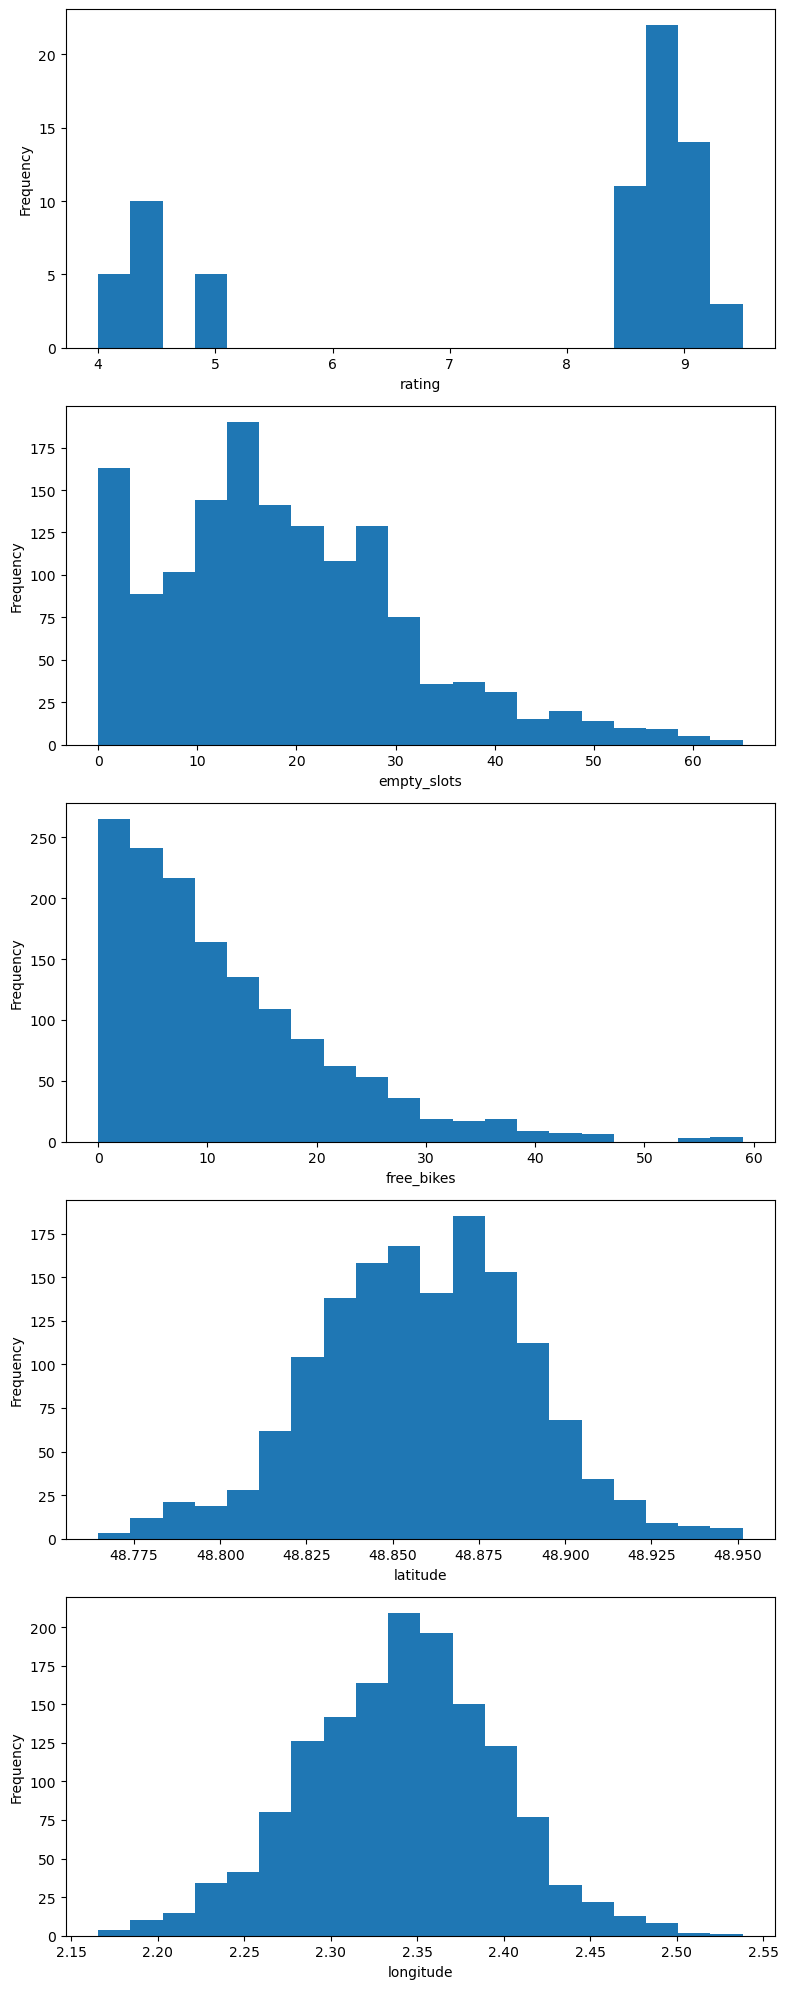

In [13]:
import matplotlib.pyplot as plt

variables = ['rating', 'empty_slots', 'free_bikes', 'latitude', 'longitude']
fig, axes = plt.subplots(len(variables), 1, figsize=(8, len(variables)*4))

for i, var in enumerate(variables):
    ax = axes[i]
    ax.hist(final_df[var].dropna(), bins=20)
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#lattitude and longitude are close to normal distribution so they should be pretty random.
#the other data is skewed so if outliers cant be found using EDA i should apply an appropraite algorithm to account for that

# Database

Put all your results in an SQLite3 database (remember, SQLite stores its databases as files in your local machine - make sure to create your database in your project's data/ directory!)

In [14]:
import sqlite3
import pandas as pd

df_non.drop("rating", axis=1, inplace=True)
df_non.to_sql('results', sqlite3.connect(r'C:\Users\juju\Desktop\statistical_modelling-_with_python\data\results.db'), if_exists='replace', index=False)



1520

Look at the data before and after the join to validate your data.

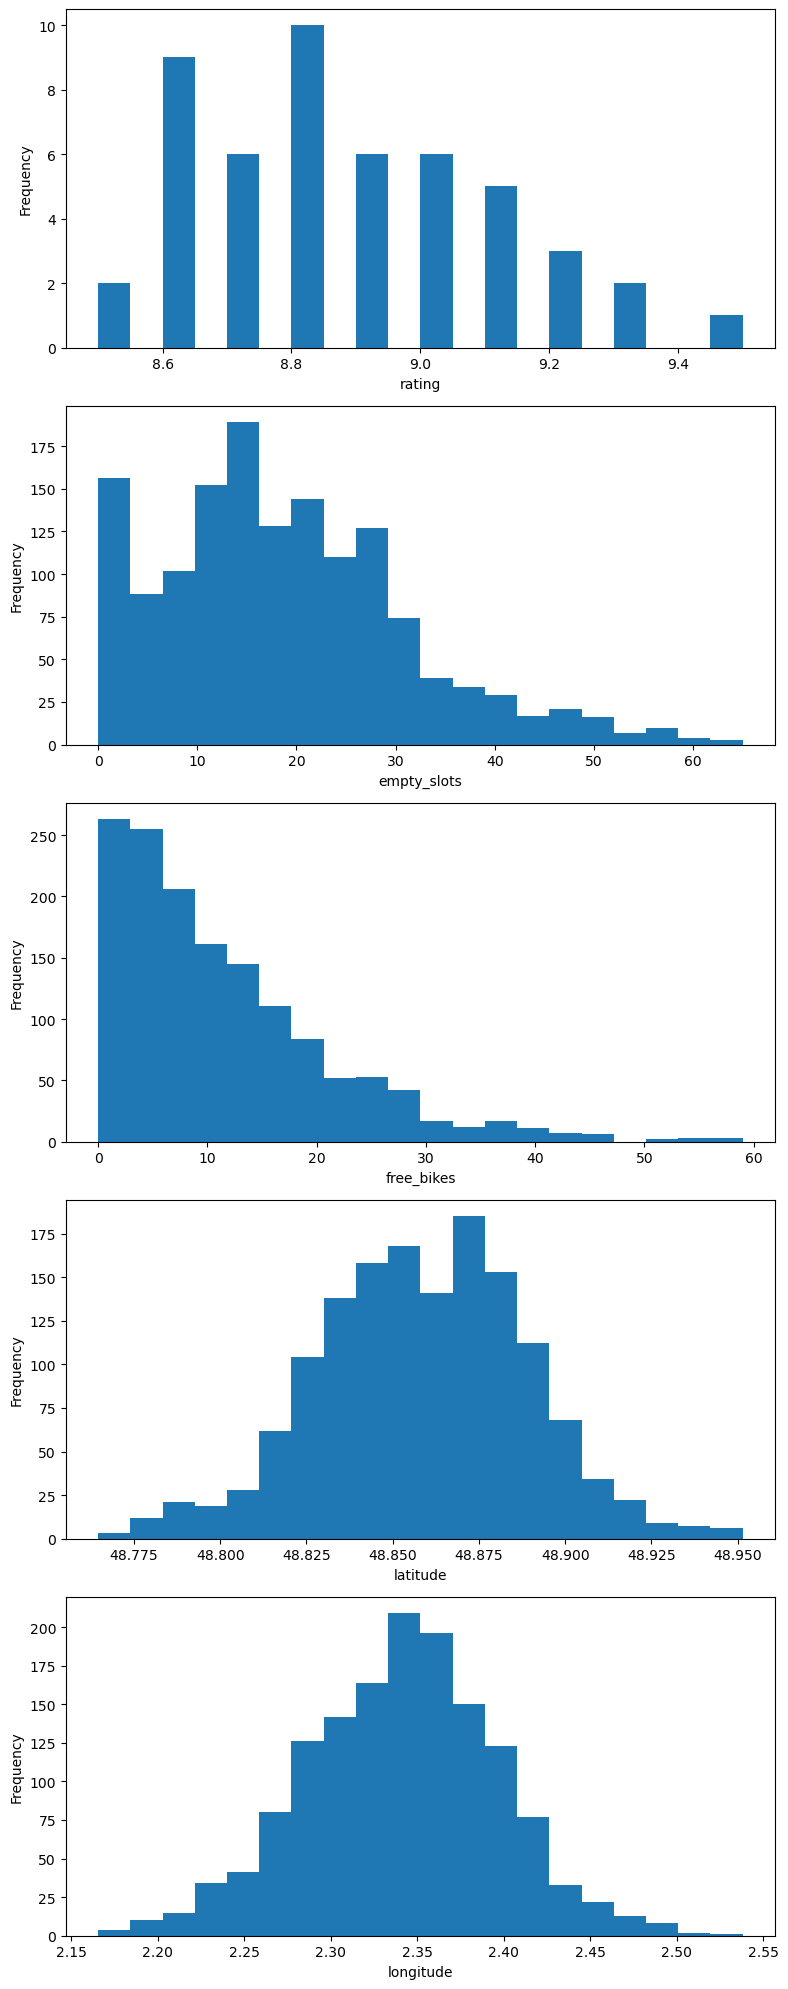

In [15]:
import matplotlib.pyplot as plt
variables = ['rating', 'empty_slots', 'free_bikes', 'latitude', 'longitude']
fig, axes = plt.subplots(len(variables), 1, figsize=(8, len(variables)*4))
for i, var in enumerate(variables):
    ax = axes[i]
    ax.hist(df_clean_cols[var].dropna(), bins=20)
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()


In [38]:
import sqlite3
conn = sqlite3.connect(r'C:\Users\juju\Desktop\statistical_modelling-_with_python\data\results.db')
df_results = pd.read_sql_query("SELECT * FROM results", conn)
print("\nData from 'results' table:")
print(df_results.info())
conn.close()



Data from 'results' table:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1500 non-null   object 
 1   name         1520 non-null   object 
 2   location     50 non-null     object 
 3   Rating       20 non-null     float64
 4   Address      20 non-null     object 
 5   Phone        20 non-null     object 
 6   empty_slots  1450 non-null   float64
 7   free_bikes   1450 non-null   float64
 8   latitude     1450 non-null   float64
 9   longitude    1450 non-null   float64
 10  timestamp    1450 non-null   object 
dtypes: float64(5), object(6)
memory usage: 130.8+ KB
None


In [ ]:
#clean the data

In [41]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect(r'C:\Users\juju\Desktop\statistical_modelling-_with_python\data\results.db')

# Define the SQL query to clean the data in the 'results' table
clean_query = """
UPDATE results
SET timestamp = DATETIME(timestamp),
    id = COALESCE(id, 'no data'),
    name = COALESCE(name, 'no data'),
    location = COALESCE(location, 'no data'),
    Rating = COALESCE(Rating, 0),
    Address = COALESCE(Address, 'no data'),
    Phone = COALESCE(Phone, 'no data'),
    empty_slots = COALESCE(empty_slots, 0),
    free_bikes = COALESCE(free_bikes, 0),
    latitude = COALESCE(latitude, 0),
    longitude = COALESCE(longitude, 0)
"""

# Execute the SQL query to clean the data
conn.execute(clean_query)

# Read the cleaned data from the 'results' table into a DataFrame
df_results_cleaned = pd.read_sql_query("SELECT * FROM results", conn)

# Close the database connection
conn.close()

# Print the cleaned DataFrame information
print("\nCleaned Data:")
print(df_results_cleaned)



Cleaned Data:
                                    id                                name  \
0             4b27effef964a5209a8c24e3                   Au Vieux Comptoir   
1             4e0766702271dfa46baee474                              Rivoli   
2             4d71280e1529a143391197a0                       Bières Cultes   
3             4b8ebd9df964a5203c3433e3                 Théâtre du Châtelet   
4             4adcda08f964a520ab3321e3                    Duc des Lombards   
...                                ...                                 ...   
1515  feddaa6b527125b9f2d1411daeef4c7c  Charles de Gaulle - Louis Philippe   
1516  df9e51f77064303346c915ac34d985aa                    Mairie de Sceaux   
1517  733584ccd52e8d354e5f533f58bbf1a5      Henri Barbusse - Marcel Cachin   
1518  77323e3c46650ca40881e62356cdd809      Charlot - Stade Gabriel Voisin   
1519  362591c2bcac06632f54009ef8c2f242             Quai du docteur Dervaux   

                                               l